In [1]:
from ridge_regression_analysis import train_ridge_regression, train_one_step_cross_validation, single_cross_validation, model_cross_validation, all_models_cross_validation

import pickle
import os 
import netCDF4 as netcdf
import skimage
import numpy as np
import torch

with open('ssp585_time_series.pkl', 'rb') as f:
    dic_ssp585 = pickle.load(f)

# Get the list of all files and directories
path = "/net/atmos/data/cmip6-ng/tos/ann/g025"
dir_list = os.listdir(path)

print("Files and directories in '", path, "' :")

list_model = []
list_forcing = []

for idx, file in enumerate(dir_list):

    file_split = file.split("_")
    
    # extract model names
    model_name = file_split[2]
    forcing = file_split[3]
    run_name = file_split[4]
    
    list_model.append(model_name)
    list_forcing.append(forcing)
    
model_names = list(set(list_model))
forcing_names = list(set(list_forcing))


# define the file
file = '/net/h2o/climphys3/simondi/cope-analysis/data/erss/sst_annual_g050_mean_19812014_centered.nc'

# read the dataset
file2read = netcdf.Dataset(file,'r')

# load longitude, latitude and sst monthly means
lon = np.array(file2read.variables['lon'][:])
lat = np.array(file2read.variables['lat'][:])
sst = np.array(file2read.variables['sst'])

# define grid
lat_grid, lon_grid = np.meshgrid(lat, lon, indexing='ij')

# first filter out the models that do not contain ensemble members 
dic_reduced_ssp585 = {}

for m in list(dic_ssp585.keys()):
    if len(dic_ssp585[m].keys()) > 2:
        dic_reduced_ssp585[m] = dic_ssp585[m].copy()
        for idx_i, i in enumerate(dic_ssp585[m].keys()):
            dic_reduced_ssp585[m][i] = skimage.transform.downscale_local_mean(dic_reduced_ssp585[m][i],(1,2,2))


# second, for each model we compute the anomalies 
dic_processed_ssp585 = {}


for idx_m,m in enumerate(dic_reduced_ssp585.keys()):
    dic_processed_ssp585[m] = dic_reduced_ssp585[m].copy()
    
    mean_ref_ensemble = 0
    for idx_i, i in enumerate(dic_reduced_ssp585[m].keys()):
        if idx_i == 0:
            mean_ref_ensemble = np.nanmean(dic_processed_ssp585[m][i][131:164,:,:],axis=0)/ len(dic_processed_ssp585[m])
        else:
            mean_ref_ensemble += np.nanmean(dic_processed_ssp585[m][i][131:164,:,:],axis=0)/ len(dic_processed_ssp585[m])
    
    for idx_i, i in enumerate(dic_processed_ssp585[m].keys()):
        dic_processed_ssp585[m][i] = dic_processed_ssp585[m][i] - mean_ref_ensemble


# compute the forced response
dic_forced_response_ssp585 = dict({})

for idx_m,m in enumerate(dic_reduced_ssp585.keys()):
    dic_forced_response_ssp585[m] = dic_reduced_ssp585[m].copy()
    
    mean_spatial_ensemble = 0
    for idx_i, i in enumerate(dic_forced_response_ssp585[m].keys()):
        
        if idx_i == 0:
            mean_spatial_ensemble = np.nanmean(dic_forced_response_ssp585[m][i],axis=(1, 2))/ len(dic_forced_response_ssp585[m])
        else:
            mean_spatial_ensemble += np.nanmean(dic_forced_response_ssp585[m][i],axis=(1, 2))/ len(dic_forced_response_ssp585[m])
            
    
    for idx_i, i in enumerate(dic_forced_response_ssp585[m].keys()):
        
        dic_forced_response_ssp585[m][i] = mean_spatial_ensemble - np.mean(mean_spatial_ensemble[131:164])


time_period = 33
grid_lat_size = 36
grid_lon_size = 72

y_forced_response = {}
x_predictor = {}

for idx_m,m in enumerate(dic_processed_ssp585.keys()):
    y_forced_response[m] = {}
    x_predictor[m] = {}
    
    for idx_i, i in enumerate(dic_forced_response_ssp585[m].keys()):
       
        y_forced_response[m][i] = dic_forced_response_ssp585[m][i][131:164]
        x_predictor[m][i] = dic_processed_ssp585[m][i][131:164,:,:]


# compute the variance
variance_processed_ssp585 = {}
std_processed_ssp585 = {}
for idx_m,m in enumerate(dic_reduced_ssp585.keys()):
    arr_tmp = np.zeros((len(dic_processed_ssp585[m].keys()),33))
    for idx_i, i in enumerate(dic_processed_ssp585[m].keys()):
        arr_tmp[idx_i,:] = np.nanmean(dic_processed_ssp585[m][i][131:164,:,:],axis=(1,2))
    variance_processed_ssp585[m] = np.mean(np.var(arr_tmp,axis=0))
    std_processed_ssp585[m] = np.mean(np.std(arr_tmp,axis=0))

Files and directories in ' /net/atmos/data/cmip6-ng/tos/ann/g025 ' :


/tmp/ipykernel_5482/294902164.py:72: RuntimeWarning: Mean of empty slice
  mean_ref_ensemble = np.nanmean(dic_processed_ssp585[m][i][131:164,:,:],axis=0)/ len(dic_processed_ssp585[m])
/tmp/ipykernel_5482/294902164.py:74: RuntimeWarning: Mean of empty slice
  mean_ref_ensemble += np.nanmean(dic_processed_ssp585[m][i][131:164,:,:],axis=0)/ len(dic_processed_ssp585[m])


In [2]:
# Data preprocessing
x_train = {}
y_train = {}

for idx_m,m in enumerate(dic_reduced_ssp585.keys()):
    x_train[m] = {}
    y_train[m] = {}
    
    for idx_i, i in enumerate(dic_processed_ssp585[m].keys()):
    
        x_train[m][i] = torch.from_numpy(np.nan_to_num(x_predictor[m][i]).reshape(x_predictor[m][i].shape[0],x_predictor[m][i].shape[1]*x_predictor[m][i].shape[2])).to(torch.float64)
        y_train[m][i] = torch.from_numpy(np.nan_to_num(y_forced_response[m][i])).to(torch.float64)
    
        nans_idx = np.where(np.isnan(x_predictor[m][i][0,:,:].ravel()))[0]
        notnans_idx = np.where(np.isnan(x_predictor[m][i][0,:,:].ravel())==False)[0]

# Load ERA5 data

In [3]:
import netCDF4 as netcdf

# define the file
file = '/net/h2o/climphys3/simondi/cope-analysis/data/erss/sst_annual_g050_mean_19812014_centered.nc'

# read the dataset
file2read = netcdf.Dataset(file,'r')

# load longitude, latitude and sst monthly means
lon = np.array(file2read.variables['lon'][:])
lat = np.array(file2read.variables['lat'][:])
sst = np.array(file2read.variables['sst'])

# define grid
lat_grid, lon_grid = np.meshgrid(lat, lon, indexing='ij')

# Read results

In [4]:
# read robust regression files
file = open('results/betas_ridge_individual.pkl', 'rb')
betas = pickle.load(file)
file.close()

file = open('results/rmse_ridge_individual.pkl', 'rb')
rmse = pickle.load(file)
file.close()

# Plot the residuals

In [5]:
###### Compute residual ##########
sst_tmp = sst[131:164,:,:].reshape((33,lon.shape[0]*lat.shape[0])).copy()
sst_tmp[np.abs(sst_tmp)> 1e20] = float('nan')
ytrue = np.nanmean(sst_tmp,axis=1)

lambda_ = 0.01


# for each model, compute the predicted values 
ypred = {}
sst_tmp_zeros = sst[131:164,:,:].reshape((33,lon.shape[0]*lat.shape[0])).copy()
sst_tmp_zeros[np.abs(sst_tmp_zeros)> 1e20] = 0.0

for idx_m, m in enumerate(x_predictor.keys()):
    beta_tmp = np.nanmean(np.array(list(betas[m][0.01].values())),axis=0)
    ypred[m] = np.matmul(beta_tmp,sst_tmp_zeros.T)

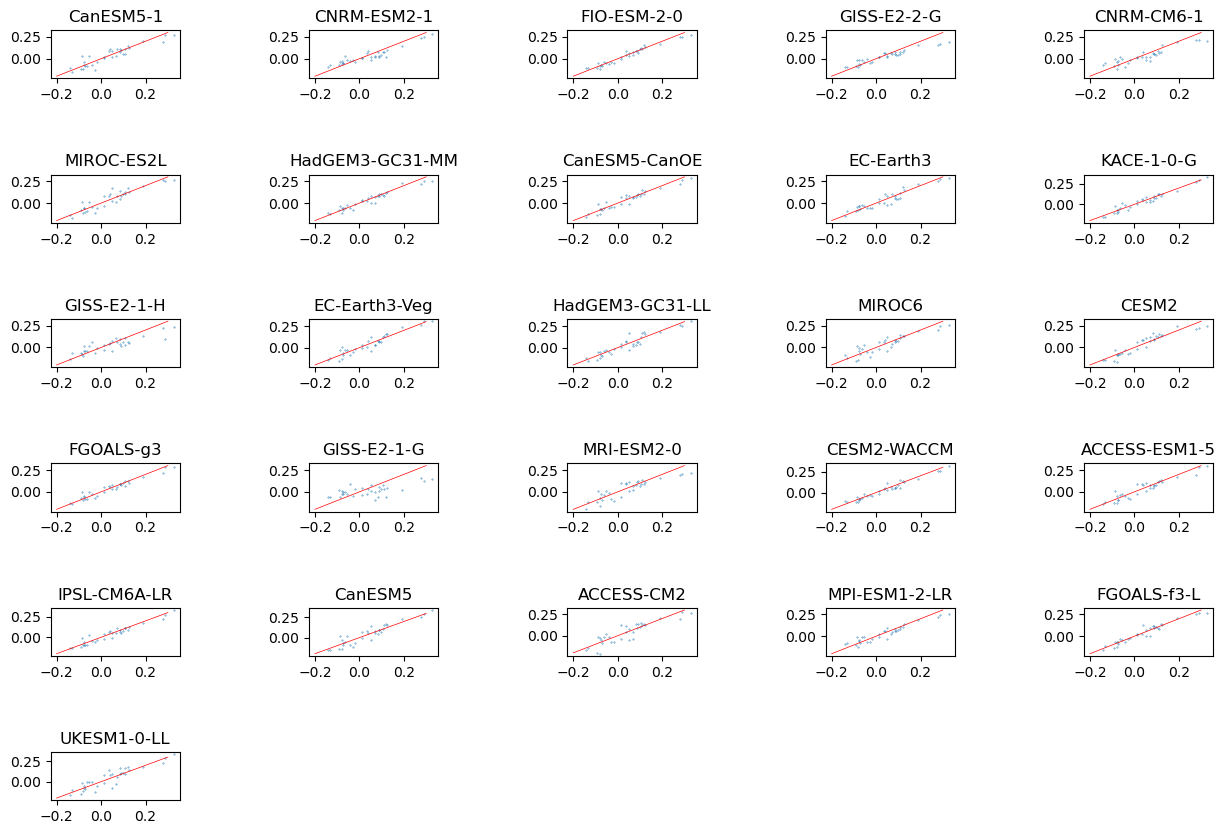

In [6]:
import matplotlib.pyplot as plt

fig, axs = plt.subplots(6,5, figsize=(15,10), facecolor='w', edgecolor='k')
fig.subplots_adjust(hspace = 2.0, wspace=1.0)

axs = axs.ravel()
    
for idx_m, m in enumerate(x_predictor.keys()):
    axs[idx_m].scatter(ytrue,ypred[m],label=m,s=0.1)
    axs[idx_m].plot(np.linspace(-0.2,0.3,10),np.linspace(-0.2,0.3,10),color='r',linewidth=0.5)
    axs[idx_m].set_title(m)

for i in range(len(x_predictor.keys()),30):
    fig.delaxes(axs[i])

plt.show()

# Analysis of the $\beta$

#### 1) PCA on the betas

In [7]:
beta_mean = {}
for idx_m,m in enumerate(betas.keys()):
    beta_mean[m] = {}
    for idx_beta,beta in enumerate(betas[m].keys()):
        beta_mean[m][beta] = np.zeros((lat.shape[0]*lon.shape[0]))
        for idx_i, i in enumerate(betas[m][beta].keys()):
            beta_mean[m][beta] += np.array(list(betas[m][beta][i]))
        beta_mean[m][beta] = beta_mean[m][beta]/len(betas[m][beta].keys())

In [8]:
best_rmse = {}
for idx_m,m in enumerate(rmse.keys()):
    best_rmse[m] = {}
    for idx_beta,beta in enumerate(betas[m].keys()):
        best_rmse[m][beta] = 0
        for idx_i, i in enumerate(betas[m][beta].keys()):
            best_rmse[m][beta] += rmse[m][beta][i]
        best_rmse[m][beta] = best_rmse[m][beta]/len(betas[m][beta].keys())

In [9]:
best_lambda = {}
for idx_m,m in enumerate(rmse.keys()):
    best_lambda[m] = min(best_rmse[m], key=best_rmse[m].get)

In [10]:
best_beta = {}
for idx_m,m in enumerate(rmse.keys()):
    best_beta[m] = beta_mean[m][best_lambda[m]]

In [11]:
best_beta_tmp = torch.from_numpy(np.array(list(best_beta.values())))

In [23]:
import torch

# run with PCA with pytorch
U,S,V = torch.pca_lowrank(best_beta_tmp, q=20, center=False, niter=10)
proj_first_comp = torch.matmul(best_beta_tmp, V[:, :20])

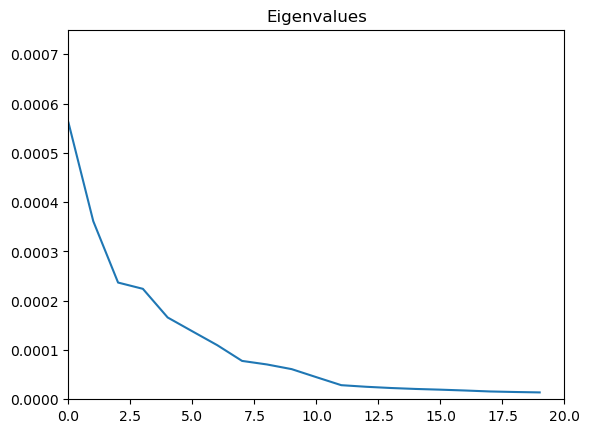

In [26]:
fig = plt.figure()
plt.plot(S**2/25)
plt.ylim((0.0,0.00075))
plt.xlim((0.0,20))
plt.title('Eigenvalues')
plt.show()

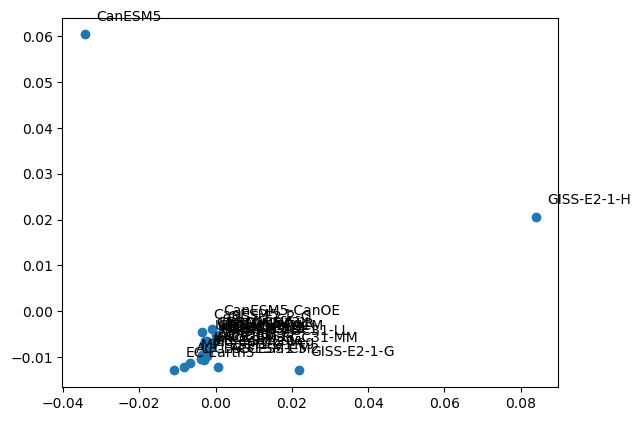

In [28]:
comp_x = 1
comp_y = 2

fig, ax = plt.subplots()
ax.scatter(proj_first_comp[:,comp_x],proj_first_comp[:,comp_y])

for idx_m, m in enumerate(dic_reduced_ssp585.keys()):
    ax.annotate(m, (proj_first_comp[idx_m,comp_x]+.003, proj_first_comp[idx_m,comp_y]+.003))

plt.show()

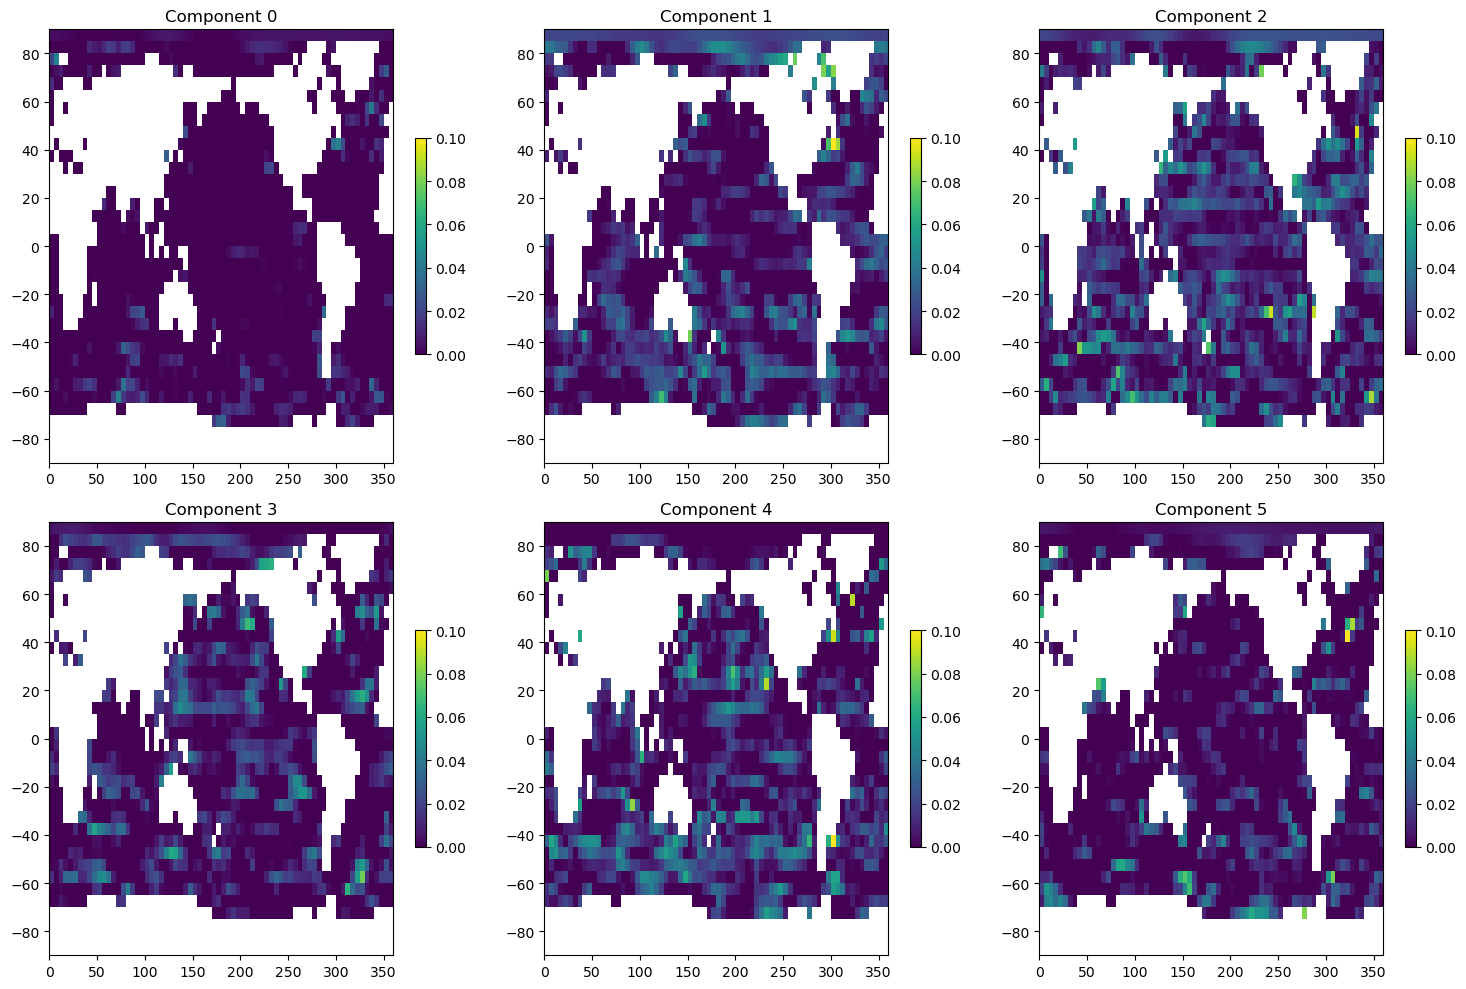

In [15]:
# plot the beta map of each mode
fig, axs = plt.subplots(2,3, figsize=(15,10), facecolor='w', edgecolor='k')
fig.subplots_adjust(hspace = 2.0, wspace=1.0)

axs = axs.ravel()
    
for k in range(6):
        
    beta_tmp = V[:,k].detach().clone()
    beta_tmp[nans_idx] = float('nan')
    beta_tmp = beta_tmp.detach().numpy().reshape(grid_lat_size,grid_lon_size)

    axs[k].set_title('Component '+ str(k))
    im0 = axs[k].pcolormesh(lon_grid,lat_grid,beta_tmp,vmin=-0.00,vmax = 0.1)

    plt.colorbar(im0, ax=axs[k], shrink=0.5)

fig.tight_layout()
plt.show()

## 2) Hierarchical clustering

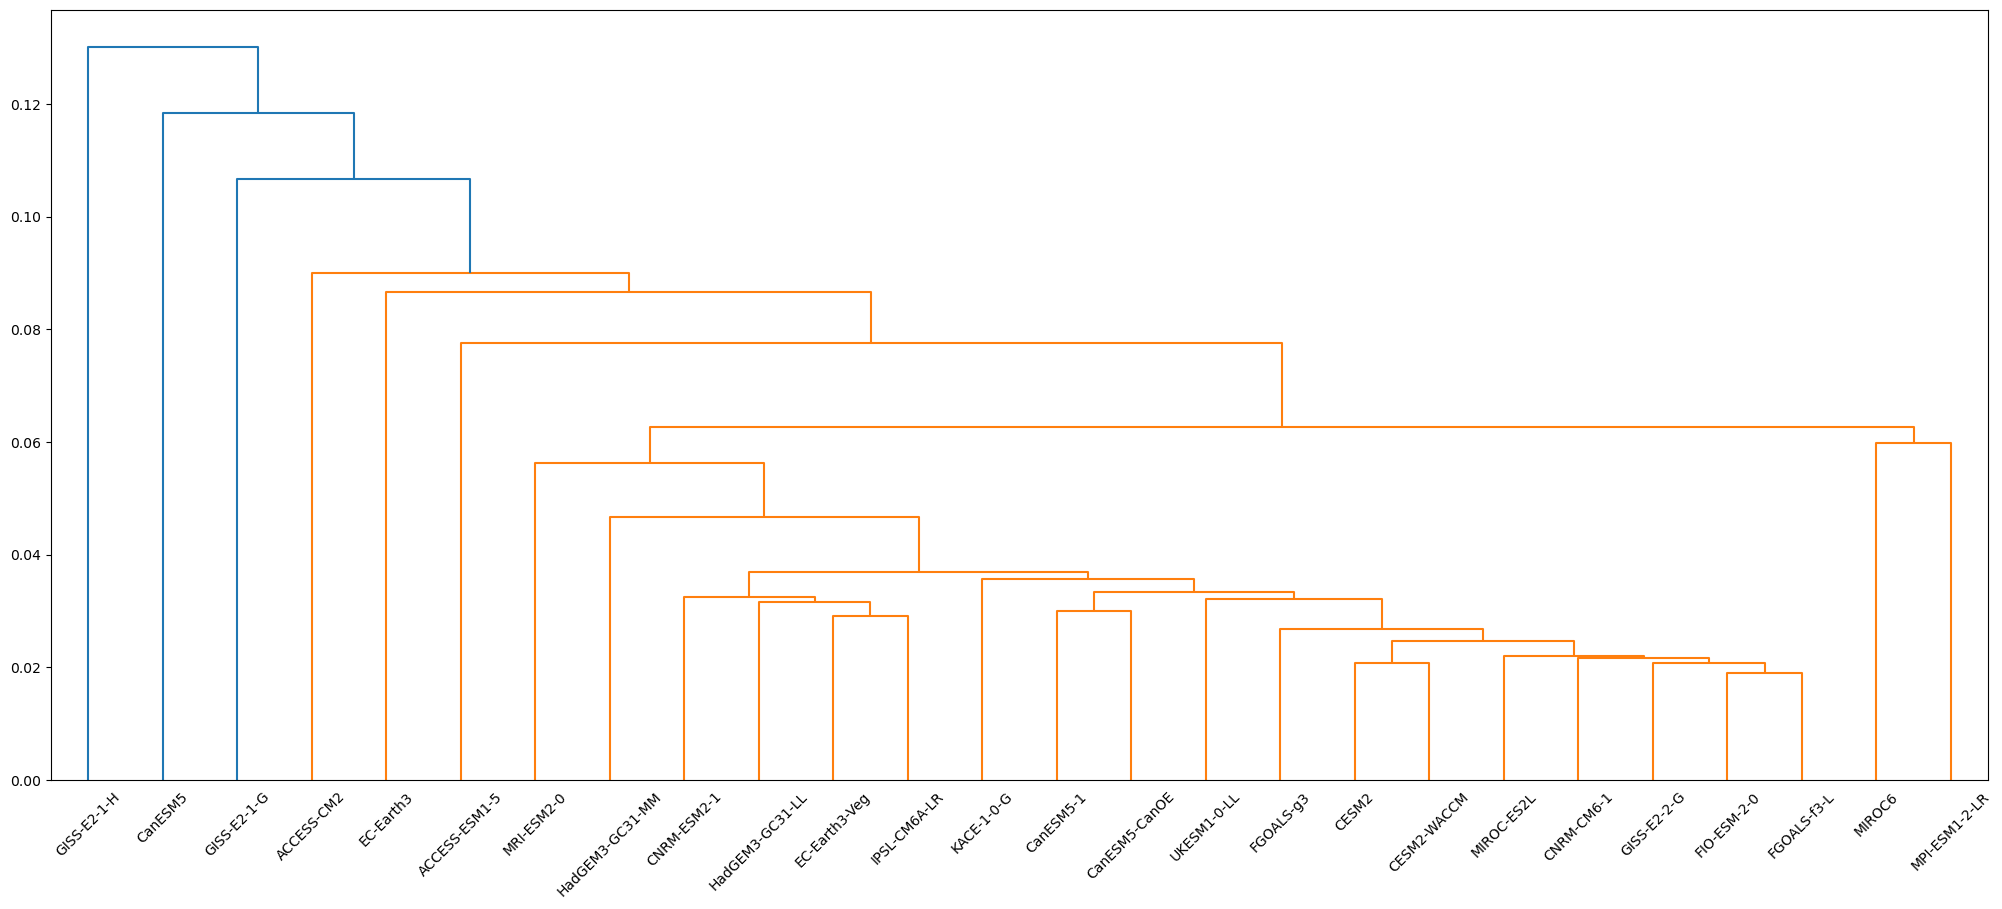

In [17]:
from scipy.cluster.hierarchy import dendrogram, linkage, leaves_list

models = list(dic_reduced_ssp585.keys())
Z1 = linkage(best_beta_tmp, 'ward')
leaves_tmp = leaves_list(Z1)

labels_tmp =  [models[int(i)] for i in leaves_tmp] 


fig = plt.figure(figsize=(25, 10))
dn = dendrogram(Z1,labels = models)

/tmp/ipykernel_5482/1075603039.py:19: UserWarning: set_ticklabels() should only be used with a fixed number of ticks, i.e. after set_ticks() or using a FixedLocator.
  ax.set_xticklabels(ordered_betas, rotation=-90)


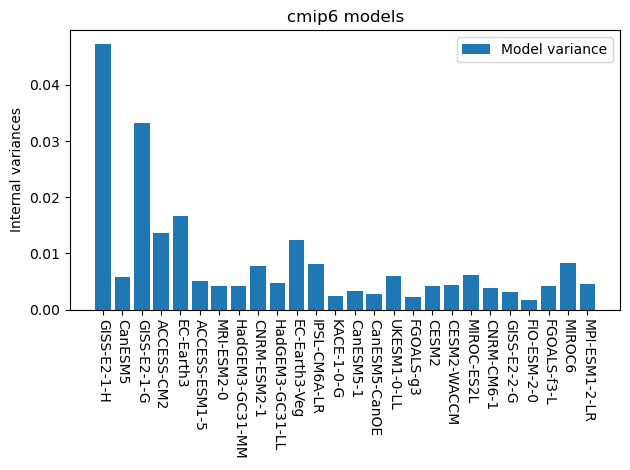

In [19]:
# compute the coefficient using soft max
M = len(list(dic_reduced_ssp585.keys()))
gamma = torch.zeros(M)
ordered_betas = [models[int(i)] for i in dn['leaves']]

for idx,i in enumerate(dn['leaves']):
    m = models[int(i)] 
    gamma[idx] = variance_processed_ssp585[m]

# plot the model contributions
fig, ax = plt.subplots()
models = list(dic_reduced_ssp585.keys())
weights = list(gamma.detach().numpy())

ax.bar(models, weights,label='Model variance')
ax.set_ylabel(r'Internal variances')
ax.set_title('cmip6 models')
ax.legend()
ax.set_xticklabels(ordered_betas, rotation=-90)
plt.tight_layout()
plt.show()

# Plot the betas according to a given ordering

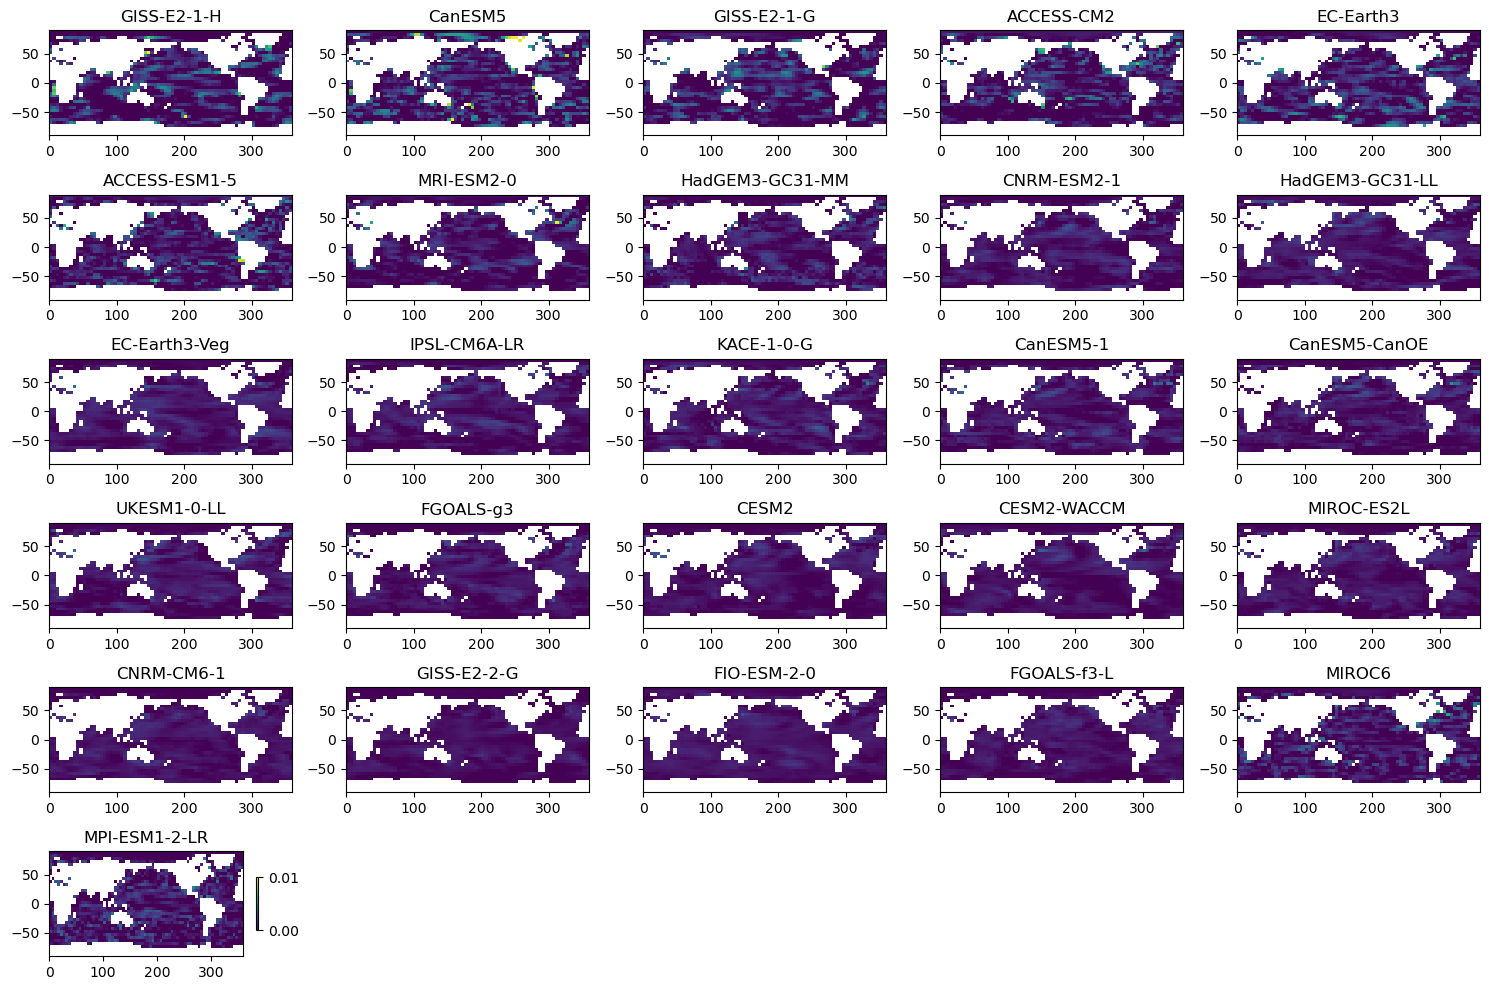

In [20]:
# plot the beta maps in the leaf-based ordering
fig, axs = plt.subplots(6,5, figsize=(15,10), facecolor='w', edgecolor='k')
fig.subplots_adjust(hspace = 2.0, wspace=1.0)

axs = axs.ravel()
    
for idx,i in enumerate(dn['leaves']):

    m = models[int(i)] 
    beta_tmp = best_beta_tmp[int(i),:].detach().clone()
    beta_tmp[nans_idx] = float('nan')
    beta_tmp = beta_tmp.detach().numpy().reshape(grid_lat_size,grid_lon_size)

    axs[idx].set_title(m)
    im0 = axs[idx].pcolormesh(lon_grid,lat_grid,beta_tmp,vmin=-0.00,vmax = 0.01)

plt.colorbar(im0, ax=axs[idx], shrink=0.5)

for i in range(len(dic_reduced_ssp585.keys()),30):
    fig.delaxes(axs[i])

fig.tight_layout()
plt.show()